# Memprediksi Kematangan Tomat dengan Menggunakan Algoritma *Convolution Neural Network*

`Faisal Kengo (FTDS Remote Batch 014)`

## Perkenalan

Nama saya Faisal Kengo, kali ini saya akan memprediksi apakah suatu tomat sudah matang atau belum dengan menggunakan algoritma *Convolution Neural Network*. *Dataset* yang disediakan terdiri dari berbagai macam gambar tomat dengan tingkat kematangan yang berbeda-beda dan diunduh dari [Kaggle.com](https://www.kaggle.com/datasets/techkhid/riped-and-unriped-tomato-dataset).

### Tujuan

Tujuan dari penyusunan laporan ini adalah sebagai berikut:

* Memprediksi klasifikasi tomat matang dan tomat belum matang lewat gambar menggunakan algoritma *Convolution Neural Network*.

## Pengolahan dan Analisa *Dataset*

### Mengimpor *Library*

Pertama-tama kita akan mengimpor *library* yang akan kita gunakan untuk mengolah data.

In [1]:
# Memuat library yang akan digunakan dalam proses analisa

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
import pickle
from google.colab.patches import cv2_imshow
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Memuat *Dataset*

Untuk laporan kali ini kita akan mengunduh data langsung lewat API Kaggle. *Token* untuk API Kaggle bisa didapatkan dari pengaturan akun Kaggle masing-masing. Setelah itu kita akan menyiapkan *folder root* dan *folder* untuk melakukan pegunduhan. Perintah di bawah dilakukan untuk Google Colab. Pada lokal, perintah di bawah dapat dilakukan dengan mengganti alamat pembuatan *folder root* dan *folder* ke alamat di mana model dijalankan.

In [2]:
# Mempersiapkan pengunduhan dataset dari Kaggle ke Colab

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle 

!mkdir ./kaggle
!mv ./kaggle.json ./kaggle

# Mengatur perizinan akses dan memeriksa file di dalam folder Kaggle

!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

# Menginstall program Kaggle ke environment Colab

!pip install -q kaggle

kaggle.json


Kemudian kita akan mengunduh *dataset* yang akan kita gunakan. *Dataset* yang diunduh melalui Kaggle memiliki format dokumen berupa '.zip'. Kita dapat langsung mengekstrak dokumen tersebut melalui perintah `unzip`.

In [3]:
# Mengunduh dataset dari Kaggle ke Colab

!kaggle datasets download -d techkhid/riped-and-unriped-tomato-dataset

# Mengekstrak dataset yang telah diunduh

!unzip -q /content/riped-and-unriped-tomato-dataset.zip -d images

 84% 121M/143M [00:01<00:00, 133MB/s]
100% 143M/143M [00:01<00:00, 123MB/s]


Setelah itu kita akan mendefinisikan variabel yang mencakup daftar gambar yang sudah diunduh dan diekstrak.

In [4]:
# Melihat isi folder gambar yang akan diidentifikasi

imglist = os.listdir("/content/images/Riped and Unriped tomato Dataset/Images")
imglist

['Riped tomato_134.jpeg',
 'unriped tomato_78.jpeg',
 'Riped tomato_270.jpeg',
 'Riped tomato_181.jpeg',
 'Riped tomato_29.jpeg',
 'Riped tomato_204.jpeg',
 'Riped tomato_87.jpeg',
 'Riped tomato_122.jpeg',
 'Riped tomato_112.jpeg',
 'Riped tomato_74.jpeg',
 'unriped tomato_32.jpeg',
 'Riped tomato_44.jpeg',
 'Riped tomato_49.jpeg',
 'Riped tomato_271.jpeg',
 'Riped tomato_102.jpeg',
 'unriped tomato_101.jpeg',
 'unriped tomato_102.jpeg',
 'unriped tomato_229.jpeg',
 'unriped tomato_288.jpeg',
 'unriped tomato_126.jpeg',
 'Riped tomato_7.jpeg',
 'unriped tomato_19.jpeg',
 'unriped tomato_25.jpeg',
 'Riped tomato_31.jpeg',
 'unriped tomato_39.jpeg',
 'Riped tomato_59.jpeg',
 'Riped tomato_32.jpeg',
 'Riped tomato_168.jpeg',
 'Riped tomato_98.jpeg',
 'unriped tomato_130.jpeg',
 'unriped tomato_82.jpeg',
 'Riped tomato_137.jpeg',
 'Riped tomato_245.jpeg',
 'unriped tomato_239.jpeg',
 'Riped tomato_100.jpeg',
 'Riped tomato_240.jpeg',
 'unriped tomato_291.jpeg',
 'Riped tomato_52.jpeg',
 '

Karena dataset yang diunduh tidak dipisahkan secara direktori, kita akan membuat *dataframe* untuk nantinya dipisahkan antara *dataset train*, *val*, dan *test* secara manual. Di *dataframe* ini kita akan mengambil informasi-informasi berikut:

* Alamat lengkap gambar yang akan diidentifikasi,

* Ukuran gambar yang diidentifikasi,

* Label dari masing-masing gambar.

In [5]:
# Mendefinisikan path utama dari gambar yang akan diidentifikasi

main_path = "/content/images/Riped and Unriped tomato Dataset/Images"

# Membuat dataframe untuk daftar gambar yang diunduh

imgpath = []
label = []
imgh = []
imgw = []
imgr = []

for i in imglist:
  imgpaths = os.path.join(main_path, i)
  if "Riped" in i:
    labels = "Ripe"
  else:
    labels = "Unripe"
  imgpath.append(imgpaths)
  label.append(labels)

for i in imglist:
  imgpaths = os.path.join(main_path, i)
  try:
    img = cv2.imread(imgpaths)
    h = img.shape[0]
    w = img.shape[1]
    ratio = h/w
    imgh.append(h)
    imgw.append(w)
    imgr.append(ratio)
  except:
    pass

imgseries = pd.Series(imgpath, name = "ImagePath")
imgheight = pd.Series(imgh, name = "Height")
imgwidth = pd.Series(imgw, name = "Width")
imgratio = pd.Series(imgr, name = "ImageRatio")
labelseries = pd.Series(label, name = "Label")


df = pd.concat([imgseries, imgheight, imgwidth, imgratio, labelseries], axis = 1)

df

,ImagePath,Height,Width,ImageRatio,Label
0,/content/images/Riped and Unriped tomato Datas...,998,1200,0.831667,Ripe
1,/content/images/Riped and Unriped tomato Datas...,448,800,0.560000,Unripe
2,/content/images/Riped and Unriped tomato Datas...,275,400,0.687500,Ripe
3,/content/images/Riped and Unriped tomato Datas...,555,740,0.750000,Ripe
4,/content/images/Riped and Unriped tomato Datas...,1536,2048,0.750000,Ripe
...,...,...,...,...,...
283,/content/images/Riped and Unriped tomato Datas...,350,700,0.500000,Ripe
284,/content/images/Riped and Unriped tomato Datas...,1800,3200,0.562500,Unripe
285,/content/images/Riped and Unriped tomato Datas...,1080,1000,1.080000,Unripe
286,/content/images/Riped and Unriped tomato Datas...,280,329,0.851064,Unripe


### *Exploratory Data Analysis*

Pertama-tama kita akan melihat terlebih dahulu bagaimana data-data yang kita miliki di dalam *dataset* yang sudah dimuat dengan perintah `.info()`:

In [6]:
# Melihat informasi pada dataframe yang dibuat

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ImagePath   288 non-null    object 
 1   Height      288 non-null    int64  
 2   Width       288 non-null    int64  
 3   ImageRatio  288 non-null    float64
 4   Label       288 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 11.4+ KB


Dari perintah di atas, kita dapat mengetahui bahwa *dataset* yang akan kita gunakan mengandung 288 buah data yang tersusun dari 5 kolom yang berbeda dan berisikan informasi alamat gambar yang akan diidentifikasi, panjang dan lebar gambar, rasio dari gambar, dan penanda apakah tomat pada gambar sudah matang atau belum.

Kemudian kita akan lihat bagaimana deskripsi matematisnya.

In [7]:
# Melihat deskripsi matematis pada dataframe yang dibuat

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Height,288.0,932.253472,796.436656,200.00000,450.000000,720.0000,1085.250000,5200.000000
Width,288.0,1256.076389,1166.501942,250.00000,739.000000,890.0000,1300.000000,7792.000000
ImageRatio,288.0,0.770047,0.239676,0.43808,0.664686,0.6875,0.821015,1.777778


Dari perintah di atas kita dapat mengetahui beberapa hal:

* Panjang gambar berada pada rentang 200 hingga 5200 pixel,

* Lebar gambar berada pada rentang 250 hingga 7792 pixel,

* Rasio gambar berada pada rentang 0.4381 hingga 1.7778.

Untuk mengetahui lebih lanjut gambar mana yang memiliki nilai panjang dan lebar yang paling kecil dan besar, kita akan melakukan beberapa *query*. Sebelum itu kita akan buat salinan dari *dataframe* yang kita miliki untuk kita urutkan agar indeks gambar dari *query* yang akan kita jalankan konsisten.

In [8]:
dfc = df.copy()
dfc = dfc.sort_values(by = "ImagePath", ascending = True)
dfc.reset_index(drop = True, inplace = True)

dfc

,ImagePath,Height,Width,ImageRatio,Label
0,/content/images/Riped and Unriped tomato Datas...,256,350,0.731429,Ripe
1,/content/images/Riped and Unriped tomato Datas...,1536,2048,0.750000,Ripe
2,/content/images/Riped and Unriped tomato Datas...,3534,5294,0.667548,Ripe
3,/content/images/Riped and Unriped tomato Datas...,800,1200,0.666667,Ripe
4,/content/images/Riped and Unriped tomato Datas...,1124,2184,0.514652,Ripe
...,...,...,...,...,...
283,/content/images/Riped and Unriped tomato Datas...,998,1500,0.665333,Unripe
284,/content/images/Riped and Unriped tomato Datas...,1030,1600,0.643750,Unripe
285,/content/images/Riped and Unriped tomato Datas...,866,1300,0.666154,Unripe
286,/content/images/Riped and Unriped tomato Datas...,1390,1110,1.252252,Unripe


Kemudian kita akan lakukan berbagai macam *query* untuk mengidentifikasi *dataset* yang akan kita gunakan. Pertama, kita akan melihat gambar dengan panjang terkecil.

In [9]:
# Mencari gambar dengan nilai tinggi terkecil berdasarkan deskripsi matematika

dfc.query("Height == 200")

,ImagePath,Height,Width,ImageRatio,Label
13,/content/images/Riped and Unriped tomato Datas...,200,250,0.8,Ripe
108,/content/images/Riped and Unriped tomato Datas...,200,250,0.8,Ripe


Lalu kita akan lihat gambar dengan panjang terbesar.

In [10]:
# Mencari gambar dengan nilai tinggi terbesar berdasarkan deskripsi matematika

dfc.query("Height == 5200")

,ImagePath,Height,Width,ImageRatio,Label
158,/content/images/Riped and Unriped tomato Datas...,5200,7792,0.667351,Unripe
187,/content/images/Riped and Unriped tomato Datas...,5200,7792,0.667351,Unripe
218,/content/images/Riped and Unriped tomato Datas...,5200,7792,0.667351,Unripe
265,/content/images/Riped and Unriped tomato Datas...,5200,7792,0.667351,Unripe


Lalu kita akan lihat gambar dengan lebar terkecil.

In [11]:
# Mencari gambar dengan nilai lebar terkecil berdasarkan deskripsi matematika

dfc.query("Width == 250")

,ImagePath,Height,Width,ImageRatio,Label
13,/content/images/Riped and Unriped tomato Datas...,200,250,0.8,Ripe
108,/content/images/Riped and Unriped tomato Datas...,200,250,0.8,Ripe


Lalu kita akan lihat gambar dengan lebar terbesar.

In [12]:
# Mencari gambar dengan nilai lebar terbesar berdasarkan deskripsi matematika

dfc.query("Width == 7792")

,ImagePath,Height,Width,ImageRatio,Label
158,/content/images/Riped and Unriped tomato Datas...,5200,7792,0.667351,Unripe
187,/content/images/Riped and Unriped tomato Datas...,5200,7792,0.667351,Unripe
218,/content/images/Riped and Unriped tomato Datas...,5200,7792,0.667351,Unripe
265,/content/images/Riped and Unriped tomato Datas...,5200,7792,0.667351,Unripe


Dari keempat perintah di ata kita dapat mengetahui bahwa gambar dengan panjang terkecil juga memiliki lebar terkecil, sedangkan gambar dengan panjang terbesar juga memiliki lebar terbesar. Terdapat dua gambar dengan ukuran terkecil dan empat gambar dengan ukuran terbesar.

Selanjutnya kita akan melihat gambar dengan rasio ukuran terkecil dan terbesar, di mana gambar dengan rasio terkecil merupakan gambar yang dimensinya sangat lebar dan gambar dengan rasio terbesar merupakan gambar yang dimensinya sangat panjang.

In [13]:
# Mencari gambar dengan rasio terkecil berdasarkan deskripsi matematika

dfc.query("ImageRatio == 0.43808")

,ImagePath,Height,Width,ImageRatio,Label
33,/content/images/Riped and Unriped tomato Datas...,1369,3125,0.43808,Ripe


In [14]:
# Mencari gambar dengan rasio terbesar berdasarkan deskripsi matematika

dfc.query("ImageRatio > 1.77777")

,ImagePath,Height,Width,ImageRatio,Label
188,/content/images/Riped and Unriped tomato Datas...,1280,720,1.777778,Unripe
273,/content/images/Riped and Unriped tomato Datas...,1280,720,1.777778,Unripe


Dari perintah di atas kita dapat mengetahui bahwa terdapat satu gambar dengan rasio terkecil dan dua gambar dengan rasio terbesar.

Kemudian kita akan melihat persebaran label gambar yang pada *dataset*.

In [15]:
# Memeriksa berapa gambar tomat matang dan tomat belum matang

df.Label.value_counts().sort_index()

Ripe      145
Unripe    143
Name: Label, dtype: int64

Kemudian kita akan buat visualisasi sederhana berupa plot batang vertikal.

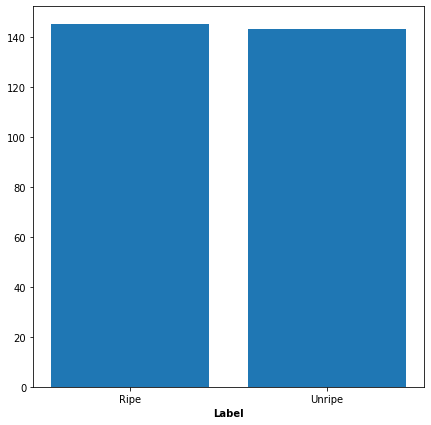

In [16]:
# Membuat visualisasi dari jumlah tomat matang dan tomat belum matang

plt.figure(figsize = (7, 7))

height = df.Label.value_counts().sort_index()

bars = (df.Label.value_counts().sort_index().index)
x_pos = np.arange(len(bars))

plt.bar(x_pos, height)
plt.xticks(x_pos, bars)
plt.xlabel("Label", fontweight = "bold")

plt.show()

Dari grafik di atas dapat terlihat bahwa *dataset* yang kita miliki memiliki jumlah gambar tomat matang dan tomat belum matang yang kurang lebih seimbang.

## *Data Preprocessing*

### Mengambil dan Memisahkan *Data Inference*

Sebelum kita membagi *dataset train* dan *dataset test*, kita pisahkan dulu beberapa buah data untuk kita lakukan *inferencing* nantinya.

In [17]:
# Memisahkan Dataset Inference

df_inf = df.sample(6, random_state = 14)
df_inf

,ImagePath,Height,Width,ImageRatio,Label
64,/content/images/Riped and Unriped tomato Datas...,440,551,0.798548,Unripe
140,/content/images/Riped and Unriped tomato Datas...,800,787,1.016518,Ripe
91,/content/images/Riped and Unriped tomato Datas...,866,1300,0.666154,Ripe
5,/content/images/Riped and Unriped tomato Datas...,463,590,0.784746,Ripe
262,/content/images/Riped and Unriped tomato Datas...,804,800,1.005000,Unripe
230,/content/images/Riped and Unriped tomato Datas...,573,840,0.682143,Unripe


Kemudian kita pisahkan sampel data tadi dari *dataset* aslinya.

In [18]:
# Reset index pada kedua dataset

df_trainvaltest = df.drop(df_inf.index)
df_trainvaltest.reset_index(drop = True, inplace = True)
df_inf.reset_index(drop = True, inplace = True)

### Memisahkan *Data Train*, *Data Val*, dan *Data Test*

Setelah kita memisahkan *dataset inference* dengan *dataset* aslinya, kita pisahkan lebih lanjut *dataset* yang sudah dipisahkan menjadi tabel fitur dan tabel target. Pada kasus ini target yang dipilih adalah kolom `Label`. Kemudian setelah itu kita akan pisahkan *dataset* menjadi *dataset train*, *dataset val*, dan *dataset test* dengan perbandingan 7:3:1.

In [19]:
# Pemisahan fitur dan target

x = df_trainvaltest.drop("Label", axis = 1)
y = df_trainvaltest["Label"]

# Pemisahan Dataset Train (70%)

x_train, x_valtest, y_train, y_valtest = train_test_split(x, y, test_size = 0.3, random_state = 14)

x_train.reset_index(drop = True, inplace = True)
x_valtest.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_valtest.reset_index(drop = True, inplace = True)

# Pemisahan Dataset Validation (20%) dan Dataset Test (10%)

x_val, x_test, y_val, y_test = train_test_split(x_valtest, y_valtest, test_size = 0.33, random_state = 14)

x_val.reset_index(drop = True, inplace = True)
x_test.reset_index(drop = True, inplace = True)
y_val.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

# Penggabungan Fitur dan Target

df_train = pd.concat([x_train, y_train], axis = 1)
df_val = pd.concat([x_val, y_val], axis = 1)
df_test = pd.concat([x_test, y_test], axis = 1)

Kemudian kita akan periksa dimensi data yang akan diolah.

In [20]:
print("Train Size:", x_train.shape)
print("Val Size:", x_val.shape)
print("Test Size:", x_test.shape)

Train Size: (197, 4)
Val Size: (56, 4)
Test Size: (29, 4)


### Mempersiapkan Data Untuk Dimasukkan ke Dalam Model

*Dataset* yang sudah kita pisahkan tadi harus kita persiapkan untuk dimasukkan ke dalam model nantinya. Kita akan tentukan terlebih dahulu berapa ukuran gambar yang akan dimasukkan ke dalam model dan dalam berapa kelompok.

In [21]:
img_height = 300
img_width = 300
SEED = 6
BATCH = 8

Setelah itu kita akan membuat fungsi proses gambar dengan menggunakan `keras.preprocessing.image.ImageDataGenerator`. Di sini kita akan lakukan *rescaling* mengingat gambar memiliki rentang 0 sampai 255 pixel.

In [22]:
# create image generator

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 0.1,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

Kemudian kita akan masukkan *dataset* yang telah dibuat ke dalam fungsi proses gambar masing-masing, di mana kolom `x` merupakan gambar yang akan diproses dan kolom `y` merupakan kolom label gambar.

In [23]:
# dari dataframe bukan directory
ds_train = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    x_col = "ImagePath",
    y_col = "Label",
    target_size = (img_height, img_width), 
    class_mode = "binary",
    batch_size = BATCH,
    shuffle = True,
    seed = SEED)

ds_val = val_datagen.flow_from_dataframe(
    dataframe = df_val,
    x_col = "ImagePath",
    y_col = "Label",
    target_size = (img_height, img_width),
    class_mode = "binary",
    batch_size = BATCH,
    shuffle = False,
    seed = SEED)

ds_test = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    x_col = "ImagePath",
    y_col = "Label",
    target_size = (img_height, img_width),
    class_mode = "binary",
    batch_size = BATCH,
    seed = SEED)

Found 197 validated image filenames belonging to 2 classes.
Found 56 validated image filenames belonging to 2 classes.
Found 29 validated image filenames belonging to 2 classes.


Kemudian kita akan periksa kelas apa berkorespondensi dengan bilangan mana.

In [24]:
ds_train.class_indices

{'Ripe': 0, 'Unripe': 1}

Dari perintah di atas kita dapat mengetahui bahwa label `Ripe` berkorespondensi dengan label `0` dan label `Unripe` berkorespondensi dengan label `1`.

## Model Construction

### *Base Model*

Sebagai acuan, kita akan membuat model dasar yang terdiri dari 3 pasang lapisan `Conv2D` 16 *filter* dan `MaxPooling2D` yang berfungsi untuk mengolah data gambar, kemudian diratakan dan dihubungkan dengan lapisan `Dense` sebelum dihubungkan dengan lapisan klasifikasi *output*. Model ini merupakan model yang sangat umum digunakan untuk melakukan klasifikasi gambar.

Untuk proses *compile*, model ini akan menggunakan *optimizer* Adam yang umumnya merupakan *optimizer* terbaik, pengukuran fungsi *loss* menggunakan *binary cross entropy* karena kita akan melakukan klasifikasi biner, dan metrik pengukuran berupa akurasi karena data yang kita miliki kurang-lebih seimbang.

In [25]:
inputs = [img_height, img_width, 3]

basemodel = keras.models.Sequential([
    keras.layers.Conv2D(16, 3, activation = "relu", input_shape = inputs),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(16, 3, activation = "relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(16, 3, activation = "relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(16, activation = "relu"),
    keras.layers.Dense(1, activation = "sigmoid")
])

basemodel.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])

basemodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 16)       0

Setelah model selesai di-*compile*, kita akan latih model tersebut. Untuk model dasar ini kita hanya akan menggunakan 20 epoch saja.

In [26]:
history_base = basemodel.fit(ds_train, batch_size = BATCH, 
                           epochs = 20, validation_data = ds_val)

Epoch 1/20
25/25 [==============================] - 25s 479ms/step - loss: 0.5875 - accuracy: 0.7310 - val_loss: 0.3053 - val_accuracy: 0.9107
Epoch 2/20
25/25 [==============================] - 12s 469ms/step - loss: 0.2973 - accuracy: 0.8832 - val_loss: 0.3400 - val_accuracy: 0.9286
Epoch 3/20
25/25 [==============================] - 12s 470ms/step - loss: 0.2886 - accuracy: 0.8883 - val_loss: 0.4266 - val_accuracy: 0.9107
Epoch 4/20
25/25 [==============================] - 12s 467ms/step - loss: 0.2991 - accuracy: 0.8680 - val_loss: 0.3089 - val_accuracy: 0.8929
Epoch 5/20
25/25 [==============================] - 12s 467ms/step - loss: 0.2967 - accuracy: 0.8934 - val_loss: 0.2813 - val_accuracy: 0.9107
Epoch 6/20
25/25 [==============================] - 12s 499ms/step - loss: 0.3163 - accuracy: 0.8985 - val_loss: 0.5573 - val_accuracy: 0.8929
Epoch 7/20
25/25 [==============================] - 11s 464ms/step - loss: 0.2715 - accuracy: 0.8782 - val_loss: 0.7805 - val_accuracy: 0.7857

Kemudian kita akan periksa perhitungan akurasi dan fungsi *loss* dari model tersebut.

In [27]:
metrics_base = pd.DataFrame(history_base.history)
metrics_base.describe()

,loss,accuracy,val_loss,val_accuracy
count,20.000000,20.000000,20.000000,20.000000
mean,0.288570,0.887817,0.388829,0.899107
std,0.075207,0.039213,0.136173,0.030807
min,0.229800,0.730964,0.259629,0.785714
25%,0.257255,0.883249,0.301789,0.892857
50%,0.271145,0.895939,0.348007,0.910714
75%,0.297717,0.904822,0.429965,0.910714
max,0.587513,0.918782,0.780468,0.928571


Dari perintah di atas, kita dapat mengetahui bahwa rata-rata akurasi dari model adalah sebesar 88.78% dengan rata-rata akurasi validasi sebesar 89.91%, serta model memiliki penalti rata-rata sebesar 0.2886 dengan penalti rata-rata validasi sebesar 0.3888. Untuk lebih jelasnya, kita dapat membuat grafik untuk menvisualisasikan akurasi model tersebut.

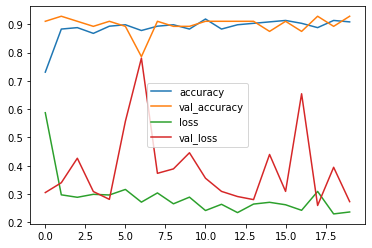

In [28]:
metrics_base[["accuracy", "val_accuracy", "loss", "val_loss"]].plot()

Dari grafik di atas dapat terlihat bahwa nilai pinalti dari *validation loss* melonjak naik pada model ini. Meskipun begitu, nilai akurasi dan validasi akurasinya berada pada nilai yang cukup tinggi.

Untuk melihat laporan klasifikasi dan matriks *confusion*, kita akan lakukan *encoding* terlebih dahulu pada tabel *y_train*, *y_test*, dan *y_val*.

In [29]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.fit_transform(y_val)
y_test_encoded = le.fit_transform(y_test)

Kemudian kita akan prediksikan klasifikasi pada *dataset test* ke dalam model dasar yang tadi sudah dilatih.

In [30]:
y_testpred_base = basemodel.predict(ds_test).round(decimals = 0)

print("---Base Model Test Report---")
print(classification_report(y_test_encoded, y_testpred_base))

---Base Model Test Report---
              precision    recall  f1-score   support

           0       0.62      0.62      0.62        16
           1       0.54      0.54      0.54        13

    accuracy                           0.59        29
   macro avg       0.58      0.58      0.58        29
weighted avg       0.59      0.59      0.59        29



Dari model di atas kita dapat melihat bahwa *recall* untuk label `Ripe` adalah sebesar 62% dan untuk label `Unripe` adalah sebesar 54%. Nilai ini menunjukkan bahwa model yang kita buat sangat *overfit* untuk *dataset* yang kita gunakan.

Kemudian kita akan lihat matriks *confusion*-nya.

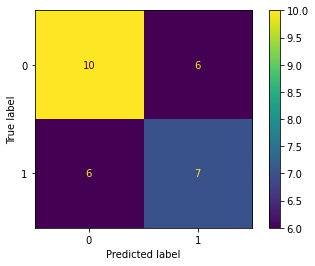

In [31]:
ConfusionMatrixDisplay(confusion_matrix(y_test_encoded, y_testpred_base)).plot()
plt.show()

Dari matriks di atas dapat terlihat bahwa tingkat *recall* model masih buruk, terlihat dari banyaknya gambar tomat matang yang diidentifikasi sebagai tomat tidak matang dan sebaliknya, sebanyak 12 gambar.

## *Model Improvement*

Pada bagian ini kita akan mencoba mengubah bagian-bagian dari model untuk melihat bagaimana pengaruhnya pada saat melakukan pelatihan.

### Model #1: Penambahan *Filter* dan *Node*

Pada model ini kita akan mencoba menambahkan jumlah *node* ke dalam model. Selain itu, kita akan melakukan penggandaan jumlah *filter* dalam lapisan `Conv2D` secara bertahap.

Kita juga akan menerapkan fungsi yang dapat memberhentikan perhitungan jika nilai *validation loss*-nya sudah stabil.

In [32]:
inputs = [img_height, img_width, 3]

model_1 = keras.models.Sequential([
    keras.layers.Conv2D(16, 3, activation = "relu", input_shape = inputs),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, activation = "relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, activation = "relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, 3, activation = "relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation = "relu"),
    keras.layers.Dense(1, activation = "sigmoid")
])

stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 15)

model_1.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 149, 149, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 35, 35, 64)      

Setelah model selesai di-*compile*, kita akan latih model tersebut. Untuk model ini kita akan menggunakan 200 epoch.

In [33]:
history_1 = model_1.fit(ds_train, batch_size = BATCH, 
                           epochs = 200, validation_data = ds_val, callbacks = stopper)

Epoch 1/200
25/25 [==============================] - 13s 483ms/step - loss: 0.5885 - accuracy: 0.7259 - val_loss: 0.5310 - val_accuracy: 0.8929
Epoch 2/200
25/25 [==============================] - 12s 480ms/step - loss: 0.3216 - accuracy: 0.8934 - val_loss: 0.4944 - val_accuracy: 0.9107
Epoch 3/200
25/25 [==============================] - 12s 474ms/step - loss: 0.3490 - accuracy: 0.8680 - val_loss: 0.3875 - val_accuracy: 0.9107
Epoch 4/200
25/25 [==============================] - 12s 465ms/step - loss: 0.2532 - accuracy: 0.8883 - val_loss: 0.5833 - val_accuracy: 0.9107
Epoch 5/200
25/25 [==============================] - 12s 474ms/step - loss: 0.2929 - accuracy: 0.8782 - val_loss: 0.3128 - val_accuracy: 0.9286
Epoch 6/200
25/25 [==============================] - 12s 475ms/step - loss: 0.3695 - accuracy: 0.8477 - val_loss: 0.3739 - val_accuracy: 0.9107
Epoch 7/200
25/25 [==============================] - 12s 469ms/step - loss: 0.2857 - accuracy: 0.8731 - val_loss: 0.4353 - val_accuracy:

Kemudian kita akan periksa perhitungan akurasi dan fungsi *loss* dari model tersebut.

In [34]:
metrics_1 = pd.DataFrame(history_1.history)
metrics_1.describe()

,loss,accuracy,val_loss,val_accuracy
count,59.000000,59.000000,59.000000,59.000000
mean,0.224116,0.912415,0.399262,0.905569
std,0.071301,0.033758,0.138552,0.033002
min,0.113287,0.725888,0.229318,0.750000
25%,0.182154,0.898477,0.304393,0.892857
50%,0.219019,0.918782,0.364756,0.910714
75%,0.243852,0.928934,0.466492,0.928571
max,0.588500,0.949239,0.919535,0.982143


Dari perintah di atas, kita dapat mengetahui bahwa rata-rata akurasi dari model adalah sebesar 91.24% dengan rata-rata akurasi validasi sebesar 90.56%, serta model memiliki penalti rata-rata sebesar 0.2241 dengan penalti rata-rata validasi sebesar 0.3993. Dari sini sudah terlihat bahwa model sudah memiliki akurasi yang lebih baik dari model sebelumnya. Kemudian kita dapat membuat grafik untuk menvisualisasikan akurasi model tersebut.

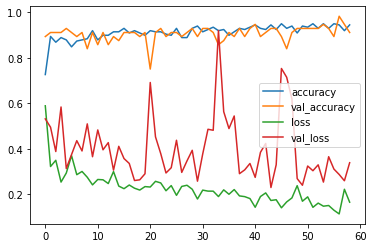

In [35]:
metrics_1[["accuracy", "val_accuracy", "loss", "val_loss"]].plot()

Dari grafik di atas dapat terlihat adanya lonjakan pada nilai *validation loss*.

Selanjutnya ita akan melihat laporan klasifikasinya.

In [36]:
y_testpred_1 = model_1.predict(ds_test).round(decimals = 0)

print("---Model #1 Test Report---")
print(classification_report(y_test_encoded, y_testpred_1))

---Model #1 Test Report---
              precision    recall  f1-score   support

           0       0.59      0.62      0.61        16
           1       0.50      0.46      0.48        13

    accuracy                           0.55        29
   macro avg       0.54      0.54      0.54        29
weighted avg       0.55      0.55      0.55        29



Dari model di atas kita dapat melihat bahwa *recall* untuk label `Ripe` adalah sebesar 62% dan untuk label `Unripe` adalah sebesar 46%. Nilai ini menunjukkan bahwa model yang kita buat sangat *overfit* untuk *dataset* yang kita gunakan. Selain itu, kita mendapati bahwa model ini lebih buruk dari model sebelumnya dalam mengidentifikasi gambar tomat yang belum matang.

Kemudian kita akan lihat matriks *confusion*-nya.

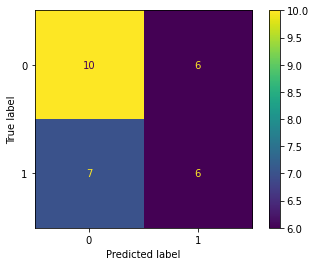

In [37]:
ConfusionMatrixDisplay(confusion_matrix(y_test_encoded, y_testpred_1)).plot()
plt.show()

Dari matriks di atas dapat terlihat bahwa tingkat *recall* model masih buruk, terlihat dari banyaknya gambar tomat matang yang diidentifikasi sebagai tomat tidak matang dan sebaliknya, sebanyak 13 gambar.

Dari model ini kita mengetahui bahwa penambahan jumlah *filter* dan *node* justru memperparah lonjakan nilai *validation loss*.

### Model #2: Jumlah *Filter* Terbesar ke Terkecil

Pada model ini kita akan menggunakan jumlah *node* yang sama dengan model pertama, namun kita menggunakan jumlah *filter* terbesar ke terkecil. Selain itu kita juga akan menerapkan fungsi untuk memberhentikan perhitungan seperti sebelumnya.

In [38]:
inputs = [img_height, img_width, 3]

model_2 = keras.models.Sequential([
    keras.layers.Conv2D(256, 3, activation = "relu", input_shape = inputs),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, 3, activation = "relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, activation = "relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, activation = "relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(16, activation = "relu"),
    keras.layers.Dense(1, activation = "sigmoid")
])

stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 15)

model_2.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 298, 298, 256)     7168      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 149, 149, 256)    0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 147, 147, 128)     295040    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 73, 73, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 71, 71, 64)        73792     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 35, 35, 64)      

Setelah model selesai di-*compile*, kita akan latih model tersebut. Untuk model ini kita akan menggunakan 200 epoch.

In [39]:
history_2 = model_2.fit(ds_train, batch_size = BATCH, 
                           epochs = 200, validation_data = ds_val, callbacks = stopper)

Epoch 1/200
25/25 [==============================] - 16s 566ms/step - loss: 0.5691 - accuracy: 0.7005 - val_loss: 0.3758 - val_accuracy: 0.9107
Epoch 2/200
25/25 [==============================] - 13s 510ms/step - loss: 0.3747 - accuracy: 0.8731 - val_loss: 0.3816 - val_accuracy: 0.9107
Epoch 3/200
25/25 [==============================] - 13s 501ms/step - loss: 0.3730 - accuracy: 0.8477 - val_loss: 0.4009 - val_accuracy: 0.8929
Epoch 4/200
25/25 [==============================] - 13s 512ms/step - loss: 0.3290 - accuracy: 0.9086 - val_loss: 0.3833 - val_accuracy: 0.9286
Epoch 5/200
25/25 [==============================] - 13s 508ms/step - loss: 0.2941 - accuracy: 0.8985 - val_loss: 0.3280 - val_accuracy: 0.9286
Epoch 6/200
25/25 [==============================] - 13s 507ms/step - loss: 0.2824 - accuracy: 0.8985 - val_loss: 0.4725 - val_accuracy: 0.8750
Epoch 7/200
25/25 [==============================] - 13s 511ms/step - loss: 0.2322 - accuracy: 0.9086 - val_loss: 0.3002 - val_accuracy:

Kemudian kita akan periksa perhitungan akurasi dan fungsi *loss* dari model tersebut.

In [40]:
metrics_2 = pd.DataFrame(history_2.history)
metrics_2.describe()

,loss,accuracy,val_loss,val_accuracy
count,31.000000,31.000000,31.000000,31.000000
mean,0.270461,0.897331,0.381313,0.895161
std,0.070443,0.041378,0.113760,0.035036
min,0.186071,0.700508,0.236107,0.732143
25%,0.229090,0.893401,0.313305,0.892857
50%,0.258245,0.903553,0.361790,0.892857
75%,0.280310,0.916244,0.408495,0.910714
max,0.569058,0.949239,0.772589,0.928571


Dari perintah di atas, kita dapat mengetahui bahwa rata-rata akurasi dari model adalah sebesar 89.73% dengan rata-rata akurasi validasi sebesar 89.52%, serta model memiliki penalti rata-rata sebesar 0.2705 dengan penalti rata-rata validasi sebesar 0.3813. Model ini memiliki akurasi yang jauh lebih buruk dibandingkan dengan model sebelumnya. Untuk lebih jelasnya, kita dapat membuat grafik untuk menvisualisasikan akurasi model tersebut.

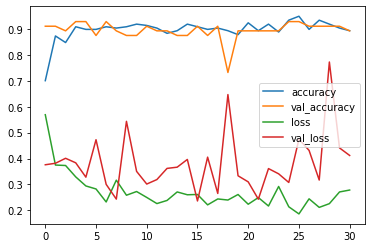

In [41]:
metrics_2[["accuracy", "val_accuracy", "loss", "val_loss"]].plot()

Dari grafik di atas terdapat lonjakan nilai *validation loss* di beberapa titik.

Selanjutnya kita akan lihat bagaimana laporan klasifikasinya.

In [42]:
y_testpred_2 = model_2.predict(ds_test).round(decimals = 0)

print("---Model #2 Test Report---")
print(classification_report(y_test_encoded, y_testpred_2))

---Model #2 Test Report---
              precision    recall  f1-score   support

           0       0.59      0.62      0.61        16
           1       0.50      0.46      0.48        13

    accuracy                           0.55        29
   macro avg       0.54      0.54      0.54        29
weighted avg       0.55      0.55      0.55        29



Dari model di atas kita dapat melihat bahwa *recall* untuk label `Ripe` adalah sebesar 62% dan untuk label `Unripe` adalah sebesar 46%. Nilai ini menunjukkan bahwa model yang kita buat sangat *overfit* untuk *dataset* yang kita gunakan. Selain itu, kita mendapati bahwa fungsi laporan klasifikasi mengeluarkan peringatan pada nilai presisi dan nilai f-nya.

Kemudian kita akan lihat matriks *confusion*-nya.

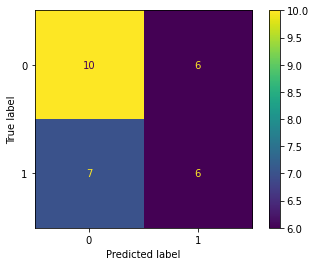

In [43]:
ConfusionMatrixDisplay(confusion_matrix(y_test_encoded, y_testpred_2)).plot()
plt.show()

Dari matriks di atas dapat terlihat bahwa tingkat *recall* model masih buruk, terlihat dari banyaknya gambar tomat matang yang diidentifikasi sebagai tomat tidak matang dan sebaliknya, sebanyak 13 gambar.

Dari model ini kita mengetahui bahwa urutan besarnya *filter* dalam suatu model tidak memengaruhi hasilnya.

### Model #3: Penambahan Lapisan *Batch Normalization* dan *Dropout*

Pada model ini kita akan berangkat dari model pertama, kemudian kita akan aplikasikan lapisan `BatchNormalization` dan `Dropout` setelah setiap lapisan konvolusi.

In [44]:
inputs = [img_height, img_width, 3]

model_3 = keras.models.Sequential([
    keras.layers.Conv2D(16, 3, activation = "relu", input_shape = inputs),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Conv2D(32, 3, activation = "relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Conv2D(64, 3, activation = "relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Conv2D(128, 3, activation = "relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(1, activation = "sigmoid")
])

stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 15)

model_3.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])

model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 149, 149, 16)     0         
 g2D)                                                            
                                                                 
 batch_normalization (BatchN  (None, 149, 149, 16)     64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 149, 149, 16)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 73, 73, 32)      

Setelah model selesai di-*compile*, kita akan latih model tersebut. Untuk model ini kita akan menggunakan 200 epoch.

In [45]:
history_3 = model_3.fit(ds_train, batch_size = BATCH, 
                           epochs = 200, validation_data = ds_val, callbacks = stopper)

Epoch 1/200
25/25 [==============================] - 13s 468ms/step - loss: 0.6452 - accuracy: 0.7919 - val_loss: 0.9991 - val_accuracy: 0.5536
Epoch 2/200
25/25 [==============================] - 12s 474ms/step - loss: 0.5047 - accuracy: 0.8376 - val_loss: 0.6720 - val_accuracy: 0.5536
Epoch 3/200
25/25 [==============================] - 12s 447ms/step - loss: 0.5183 - accuracy: 0.8376 - val_loss: 0.7509 - val_accuracy: 0.5536
Epoch 4/200
25/25 [==============================] - 12s 475ms/step - loss: 0.3508 - accuracy: 0.8426 - val_loss: 0.9352 - val_accuracy: 0.5536
Epoch 5/200
25/25 [==============================] - 12s 446ms/step - loss: 0.2116 - accuracy: 0.9137 - val_loss: 0.7280 - val_accuracy: 0.6250
Epoch 6/200
25/25 [==============================] - 12s 470ms/step - loss: 0.3771 - accuracy: 0.8832 - val_loss: 0.5537 - val_accuracy: 0.7500
Epoch 7/200
25/25 [==============================] - 12s 472ms/step - loss: 0.2810 - accuracy: 0.9188 - val_loss: 0.5790 - val_accuracy:

Kemudian kita akan periksa perhitungan akurasi dan fungsi *loss* dari model tersebut.

In [46]:
metrics_3 = pd.DataFrame(history_3.history)
metrics_3.describe()

,loss,accuracy,val_loss,val_accuracy
count,66.000000,66.000000,66.000000,66.000000
mean,0.260266,0.908629,0.354350,0.882576
std,0.090866,0.032055,0.364654,0.122244
min,0.137069,0.791878,0.139354,0.500000
25%,0.201688,0.893401,0.204150,0.879464
50%,0.248532,0.913706,0.231611,0.928571
75%,0.298467,0.923858,0.345975,0.946429
max,0.645222,0.964467,2.639500,0.982143


Dari perintah di atas, kita dapat mengetahui bahwa rata-rata akurasi dari model adalah sebesar 90.86% dengan rata-rata akurasi validasi sebesar 88.25%, serta model memiliki penalti rata-rata sebesar 0.2603 dengan penalti rata-rata validasi sebesar 0.3544. Model ini lebih baik dibandingkan dengan model pertama secara nilai akurasi dan *loss*. Untuk lebih jelasnya, kita dapat membuat grafik untuk menvisualisasikan akurasi model tersebut.

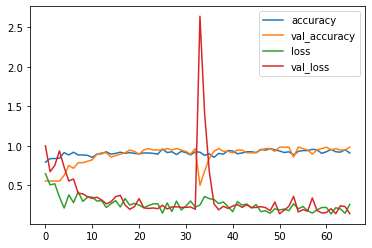

In [47]:
metrics_3[["accuracy", "val_accuracy", "loss", "val_loss"]].plot()

Dari grafik di atas kita dapat melihat bahwa nilai akurasi dan *loss* tidak sestabil pada model pertama meskipun trennya masih bisa dibilang bagus, meskipun di suatu titik nilai *validation loss*-nya melunjak sangat tinggi.

Selanjutnya kita akan lihat bagaimana laporan klasifikasinya.

In [48]:
y_testpred_3 = model_3.predict(ds_test).round(decimals = 0)

print("---Model #3 Test Report---")
print(classification_report(y_test_encoded, y_testpred_3))

---Model #3 Test Report---
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        16
           1       0.38      0.38      0.38        13

    accuracy                           0.45        29
   macro avg       0.44      0.44      0.44        29
weighted avg       0.45      0.45      0.45        29



Dari model di atas kita dapat melihat bahwa *recall* untuk label `Ripe` adalah sebesar 50% dan untuk label `Unripe` adalah sebesar 38%. Nilai ini menunjukkan bahwa model yang kita buat sangat *overfit* untuk *dataset* yang kita gunakan. Nilai ini juga lebih buruk dibandingkan dengan model identifikasi model sebelumnya.

Kemudian kita akan lihat matriks *confusion*-nya.

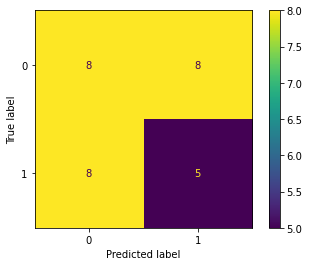

In [49]:
ConfusionMatrixDisplay(confusion_matrix(y_test_encoded, y_testpred_3)).plot()
plt.show()

Dari matriks di atas dapat terlihat bahwa tingkat *recall* model masih buruk, terlihat dari banyaknya gambar tomat matang yang diidentifikasi sebagai tomat tidak matang dan sebaliknya, sebanyak 16 gambar.

Dari model ini kita mengetahui bahwa `BatchNormalization` dan `Dropout` memiliki pengaruh negatif terhadap hasil *recall*.

### Model #4: Mengurangi Jumlah *Node*

Untuk model ini, kita berangkat dari model ketiga, namun kita akan kurangi jumlah lapisan `Conv2D` yang akan kita gunakan. Selebihnya kita hanya akan tetap menggunakan lapisan `BatchNormalization` diantara masing-masing lapisan `Conv2D` untuk model ini.

In [50]:
inputs = [img_height, img_width, 3]

model_4 = keras.models.Sequential([
    keras.layers.Conv2D(128, 3, activation = "relu", input_shape = inputs),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, 3, activation = "relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(16, activation = "relu"),
    keras.layers.Dense(1, activation = "sigmoid")
])

stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 15)

model_4.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])

model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 298, 298, 128)     3584      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 149, 149, 128)    0         
 g2D)                                                            
                                                                 
 batch_normalization_5 (Batc  (None, 149, 149, 128)    512       
 hNormalization)                                                 
                                                                 
 conv2d_16 (Conv2D)          (None, 147, 147, 32)      36896     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                            
                                                      

Setelah model selesai di-*compile*, kita akan latih model tersebut. Untuk model ini kita akan menggunakan 200 epoch.

In [51]:
history_4 = model_4.fit(ds_train, batch_size = BATCH, 
                           epochs = 200, validation_data = ds_val, callbacks = stopper)

Epoch 1/200
25/25 [==============================] - 14s 495ms/step - loss: 8.2071 - accuracy: 0.7462 - val_loss: 2.7684 - val_accuracy: 0.5357
Epoch 2/200
25/25 [==============================] - 12s 484ms/step - loss: 6.1364 - accuracy: 0.7513 - val_loss: 0.7699 - val_accuracy: 0.5000
Epoch 3/200
25/25 [==============================] - 12s 495ms/step - loss: 4.5312 - accuracy: 0.7766 - val_loss: 0.6829 - val_accuracy: 0.4643
Epoch 4/200
25/25 [==============================] - 12s 483ms/step - loss: 2.8048 - accuracy: 0.7614 - val_loss: 0.6829 - val_accuracy: 0.4464
Epoch 5/200
25/25 [==============================] - 12s 485ms/step - loss: 3.7557 - accuracy: 0.8223 - val_loss: 0.4172 - val_accuracy: 0.8750
Epoch 6/200
25/25 [==============================] - 12s 485ms/step - loss: 3.2171 - accuracy: 0.8173 - val_loss: 0.4807 - val_accuracy: 0.8571
Epoch 7/200
25/25 [==============================] - 12s 479ms/step - loss: 2.7474 - accuracy: 0.8426 - val_loss: 2.5644 - val_accuracy:

Kemudian kita akan periksa perhitungan akurasi dan fungsi *loss* dari model tersebut.

In [52]:
metrics_4 = pd.DataFrame(history_4.history)
metrics_4.describe()

,loss,accuracy,val_loss,val_accuracy
count,20.000000,20.000000,20.000000,20.000000
mean,2.578035,0.827411,0.992293,0.652679
std,1.918559,0.049435,0.724131,0.170344
min,0.283293,0.746193,0.417193,0.446429
25%,1.372419,0.785533,0.589817,0.513393
50%,2.106087,0.827411,0.682906,0.589286
75%,2.907856,0.855330,0.968716,0.830357
max,8.207061,0.913706,2.768448,0.928571


Dari perintah di atas, kita dapat mengetahui bahwa rata-rata akurasi dari model adalah sebesar 82.74% dengan rata-rata akurasi validasi sebesar 65.27%, serta model memiliki penalti rata-rata sebesar 2.578 dengan penalti rata-rata validasi sebesar 0.9923. Model ini memiliki nilai *loss* yang sangat besar sehingga dikhawatirkan akan lebih sering menghasilkan kesalahan penting. Untuk lebih jelasnya, kita dapat membuat grafik untuk menvisualisasikan akurasi model tersebut.

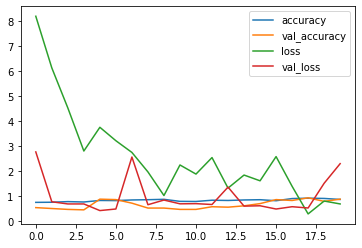

In [53]:
metrics_4[["accuracy", "val_accuracy", "loss", "val_loss"]].plot()

Dari grafik di atas bahwa nilai *loss* model ini berada pada nilai yang tidak wajar, di mana kita menginginkan nilai *loss* berada di bawah 1 namun model ini bisa menghasilkan nilai *loss* hingga 16.

Selanjutnya kita akan lihat bagaimana laporan klasifikasinya.

In [54]:
y_testpred_4 = model_4.predict(ds_test).round(decimals = 0)

print("---Model #4 Test Report---")
print(classification_report(y_test_encoded, y_testpred_4))

---Model #4 Test Report---
              precision    recall  f1-score   support

           0       0.56      0.56      0.56        16
           1       0.46      0.46      0.46        13

    accuracy                           0.52        29
   macro avg       0.51      0.51      0.51        29
weighted avg       0.52      0.52      0.52        29



Dari model di atas kita dapat melihat bahwa *recall* untuk label `Ripe` adalah sebesar 56% dan untuk label `Unripe` adalah sebesar 46%. Nilai ini menunjukkan bahwa model yang kita buat sangat *overfit* untuk *dataset* yang kita gunakan. Nilai ini juga lebih buruk dibandingkan dengan model matriks pertama.

Kemudian kita akan lihat matriks *confusion*-nya.

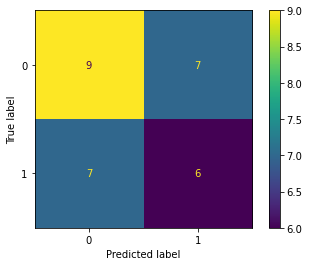

In [55]:
ConfusionMatrixDisplay(confusion_matrix(y_test_encoded, y_testpred_4)).plot()
plt.show()

Dari matriks di atas dapat terlihat bahwa tingkat *recall* model masih buruk, terlihat dari banyaknya gambar tomat matang yang diidentifikasi sebagai tomat tidak matang dan sebaliknya, sebanyak 14 gambar.

Dari model ini kita mengetahui bahwa pengurangan *node* hanya mengakibatkan ledakan nilai *loss* yang lebih tidak terkendali.

### Model Final

Dari model dasar dan keempat model eksperimen tadi, kita dapat mengetahui beberapa hal. Di antaranya:

* Secara umum, model pertama merupakan model terbaik dari model-model yang telah dilatih,

* Urutan *filter* berdasarkan ukuran tidak terlalu penting,

* `BatchNormalization` dan `Dropout` memiliki efek negatif terhadap *recall* model,

* Model harus memiliki lebih dari 3 lapisan `Conv2D` untuk menghindari ledakan nilai *loss*,

Maka kita akan membuat model ini untuk memperbaiki model-model sebelumnya. Di mana kita hanya akan menggunakan *filter* dalam jumlah sedikit namun memiliki lapisan yang lebih banyak tanpa lapisan `BatchNormalization` dan `Dropout`. Selain itu kita juga akan memperbesar nilai kesabaran dari fungsi pemberhenti perhitungan.

In [56]:
inputs = [img_height, img_width, 3]

model_final = keras.models.Sequential([
    keras.layers.Conv2D(8, 3, activation = "relu", input_shape = inputs),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(8, 3, activation = "relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(8, 3, activation = "relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, activation = "relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation = "relu"),
    keras.layers.Dense(1, activation = "sigmoid")
])

stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 20)

model_final.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])

model_final.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 298, 298, 8)       224       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 149, 149, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 147, 147, 8)       584       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 73, 73, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 71, 71, 8)         584       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 35, 35, 8)       

Setelah model selesai di-*compile*, kita akan latih model tersebut. Untuk model ini kita akan menggunakan 200 epoch.

In [57]:
history_final = model_final.fit(ds_train, batch_size = BATCH, 
                           epochs = 200, validation_data = ds_val, callbacks = stopper)

Epoch 1/200
25/25 [==============================] - 13s 493ms/step - loss: 0.6449 - accuracy: 0.6041 - val_loss: 0.4872 - val_accuracy: 0.7857
Epoch 2/200
25/25 [==============================] - 12s 486ms/step - loss: 0.4356 - accuracy: 0.8173 - val_loss: 0.3707 - val_accuracy: 0.8929
Epoch 3/200
25/25 [==============================] - 12s 482ms/step - loss: 0.3417 - accuracy: 0.8579 - val_loss: 0.2888 - val_accuracy: 0.9107
Epoch 4/200
25/25 [==============================] - 12s 467ms/step - loss: 0.3092 - accuracy: 0.8680 - val_loss: 0.3129 - val_accuracy: 0.9107
Epoch 5/200
25/25 [==============================] - 12s 475ms/step - loss: 0.3702 - accuracy: 0.8528 - val_loss: 0.5066 - val_accuracy: 0.9107
Epoch 6/200
25/25 [==============================] - 12s 475ms/step - loss: 0.3081 - accuracy: 0.8883 - val_loss: 0.4319 - val_accuracy: 0.9107
Epoch 7/200
25/25 [==============================] - 12s 464ms/step - loss: 0.2755 - accuracy: 0.8985 - val_loss: 0.4154 - val_accuracy:

Kemudian kita akan periksa perhitungan akurasi dan fungsi *loss* dari model tersebut.

In [58]:
metrics_final = pd.DataFrame(history_final.history)
metrics_final.describe()

,loss,accuracy,val_loss,val_accuracy
count,56.000000,56.000000,56.000000,56.000000
mean,0.240986,0.903372,0.353280,0.903061
std,0.076491,0.046934,0.078092,0.024990
min,0.157544,0.604061,0.245909,0.785714
25%,0.196917,0.898477,0.288761,0.892857
50%,0.234618,0.911168,0.333276,0.910714
75%,0.256854,0.923858,0.405877,0.910714
max,0.644939,0.964467,0.563246,0.946429


Dari perintah di atas, kita dapat mengetahui bahwa rata-rata akurasi dari model adalah sebesar 90.34% dengan rata-rata akurasi validasi sebesar 90.3%, serta model memiliki penalti rata-rata sebesar 0.241 dengan penalti rata-rata validasi sebesar 0.3533. Hasil ini sudah lebih baik dibandingkan dengan model pertama dan model dasar yang kita buat sebelumnya. Untuk lebih jelasnya, kita dapat membuat grafik untuk menvisualisasikan akurasi model tersebut.

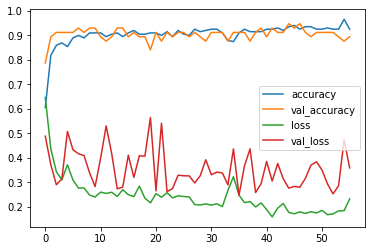

In [59]:
metrics_final[["accuracy", "val_accuracy", "loss", "val_loss"]].plot()

Dari grafik di atas kita dapat melihat bahwa nilai *validation loss*-nya masih tidak stabil, meskipun lebih terkendali.

Selanjutnya kita akan lihat bagaimana laporan klasifikasinya.

In [60]:
y_testpred_final = model_final.predict(ds_test).round(decimals = 0)

print("---Final Model Test Report---")
print(classification_report(y_test_encoded, y_testpred_final))

---Final Model Test Report---
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        16
           1       0.38      0.38      0.38        13

    accuracy                           0.45        29
   macro avg       0.44      0.44      0.44        29
weighted avg       0.45      0.45      0.45        29



Dari model di atas kita dapat melihat bahwa *recall* untuk label `Ripe` adalah sebesar 50% dan untuk label `Unripe` adalah sebesar 38%. Nilai ini menunjukkan bahwa model yang kita buat sangat *overfit* untuk *dataset* yang kita gunakan. Nilai ini juga lebih buruk dibandingkan dengan model matriks pertama.

Kemudian kita akan lihat matriks *confusion*-nya.

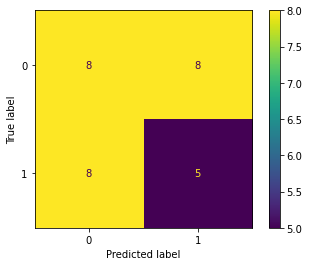

In [61]:
ConfusionMatrixDisplay(confusion_matrix(y_test_encoded, y_testpred_final)).plot()
plt.show()

Dari matriks di atas dapat terlihat bahwa tingkat *recall* model masih buruk, terlihat dari banyaknya gambar tomat matang yang diidentifikasi sebagai tomat tidak matang dan sebaliknya, sebanyak 16 gambar.

Umumnya penambahan lapisan dapat memperbaiki hasil identifikasi gambar. Namun, mengingat *dataset* training yang dimiliki tidak terlalu banyak, maka model akan sangat rentan untuk *overfitting*.

## *Inferencing*

Untuk melakukan *inferencing*, kita harus melakukan *rescaling* terlebih dahulu gambar yang akan digunakan.

In [62]:
inf_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

ds_inf = inf_datagen.flow_from_dataframe(
    dataframe = df_inf,
    x_col = "ImagePath",
    y_col = "Label",
    target_size = (img_height, img_width),
    class_mode = "binary",
    batch_size = BATCH,
    seed = SEED)

Found 6 validated image filenames belonging to 2 classes.


Kemudian kita bisa langsung lakukan prediksi dengan menggunakan model final dan model dasar yang telah disusun sebelumnya.

In [67]:
y_inf = pd.DataFrame(le.transform(df_inf.Label), columns = ["LabelReal"])
y_inf_best = pd.DataFrame(basemodel.predict(ds_inf), columns = ["LabelBasePred"]).round(decimals = 0)
y_inf_final = pd.DataFrame(model_final.predict(ds_inf), columns = ["LabelFinalPred"]).round(decimals = 0)

pd.concat([y_inf, y_inf_best, y_inf_final], axis = 1)

,LabelReal,LabelBasePred,LabelFinalPred
0,1,1.0,1.0
1,0,1.0,1.0
2,0,1.0,0.0
3,0,0.0,1.0
4,1,0.0,0.0
5,1,1.0,1.0


## Kesimpulan

Berikut adalah beberapa hal yang dapat kita simpulkan dari analisis yang sudah dibuat:

* Berdasarkan EDA, kita ketahui bahwa data yang digunakan merupakan data gambar tomat matang dan tomat tidak matang yang berjumlah 288 buah yang kemudian dibagi menjadi *dataset train*, *dataset val*, dan *dataset test*,

* Model-model yang dilatih umumnya mengalami permasalahan yang serupa, yaitu model mengalami nilai lonjakan *validation loss* pada saat dilatih. Hal ini mungkin disebabkan oleh kecilnya sampel data untuk pelatihan sehingga model lebih rentan mengalami *overfit* dan lebih rentan mengalami 'ledakan' nilai *validation loss*,

* Karena model sangat rentan terhadap resiko ledakan nilai *validation loss*, maka model terbaik yang digunakan untuk model ini adalah model dasar dengan nilai *recall* label `Ripe` sebesar 62% dan nilai *recall* label `Unripe`sebesar 54%.

## Tambahan: Menyimpan Model untuk *Deployment*

Perintah di bawah digunakan untuk mengambil model yang akan digunakan untuk *deployment*. Model yang akan digunakan adalah model dasar yang paling pertama dibangun.

In [69]:
with open("inf_datagen.pkl", "wb") as inf_imagegenerator:
    pickle.dump(inf_datagen, inf_imagegenerator)

basemodel.save("model_p2m2")

! zip -r model_p2m2.zip model_p2m2

updating: model_p2m2/ (stored 0%)
updating: model_p2m2/assets/ (stored 0%)
updating: model_p2m2/variables/ (stored 0%)
updating: model_p2m2/variables/variables.index (deflated 68%)
updating: model_p2m2/variables/variables.data-00000-of-00001 (deflated 13%)
updating: model_p2m2/saved_model.pb (deflated 89%)
updating: model_p2m2/keras_metadata.pb (deflated 92%)
